# Przetwarzanie wstępne. Filtracja kontekstowa.


### Cel:
- zapoznanie z pojęciem kontekstu / filtracji kontekstowej,
- zapoznanie z pojęciem konwolucji (splotu),
- zapoznanie z wybranymi filtrami:
	- filtry liniowe dolnoprzepustowe:
		- filtr uśredniający,
		- filtr Gaussa.
	- filtry nielinowe:
		- mediana,
		- mediana dla obrazów kolorowych.
	- filtry liniowe górnoprzepustowe:
			- laplasjan,
			- operator Robersta, Prewitta, Sobela.
- zadanie domowe: adaptacyjna filtracja medianowa.

### Filtry liniowe uśredniające (dolnoprzepustowe)

Jest to podstawowa rodzina filtrów stosowana w cyfrowym przetwarzaniu obrazów. 
Wykorzystuje się je w celu "rozmazania" obrazu i tym samym redukcji szumów (zakłóceń) na obrazie.
Filtr określony jest przez dwa parametry: rozmiar maski (ang. _kernel_) oraz wartości współczynników maski.

Warto zwrócić uwagę, że omawiane w niniejszym rozdziale operacje generują nową wartość piksela na podstawie pewnego fragmentu obrazu (tj. kontekstu), a nie jak operacje punktowe tylko na podstawie jednego piksela.


1. Wczytaj obraz _plansza.png_.
W dalszej części ćwiczenia sprawdzenie działania filtracji dla innych obrazów sprowadzi się do wczytania innego pliku.

2. Podstawowa funkcja to `cv2.filter2D`  - realizacja filtracji konwolucyjnej.
   Proszę sprawdzić jej dokumentację i zwrócić uwagę na obsługę problemu brzegowego (na krawędziach istnieją piksele dla których nie da się wyznaczyć otoczenia).

  Uwaga. Problem ten można też rozwiązać z użyciem funkcji `signal.convolve2d` z biblioteki _scipy_ (`from scipy import signal`).

In [1]:
import cv2
import os
import requests
from matplotlib import pyplot as plt
import numpy as np
from scipy import signal

url = 'https://raw.githubusercontent.com/vision-agh/poc_sw/master/06_Context/'

fileNames = ["jet.png", "kw.png", "moon.png", "lenaSzum.png", "lena.png", "plansza.png"]
for fileName in fileNames:
  if not os.path.exists(fileName):
      r = requests.get(url + fileName, allow_redirects=True)
      open(fileName, 'wb').write(r.content)



3. Stwórz podstawowy filtr uśredniający o rozmiarze $3 \times 3$ -- za pomocą funkcji `np.ones`. Wykonaj konwolucję na wczytanym obrazie. Na wspólnym rysunku wyświetl obraz oryginalny, po filtracji oraz moduł z różnicy.

4. Przeanalizuj otrzymane wyniki. Jakie elementy zawiera obraz "moduł z różnicy"? Co na tej podstawie można powiedzieć o filtracji dolnoprzepustowej?

In [5]:
def read_img(filename):
    image = cv2.imread(filename)
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

def plot_img(img, cmap='gray', title=''):
    plt.figure(figsize=(img.shape[0]/30,img.shape[1]/30))
    plt.imshow(img, cmap=cmap, vmin=0, vmax=255)
    plt.axis('off')
    plt.title(title)
    plt.show()

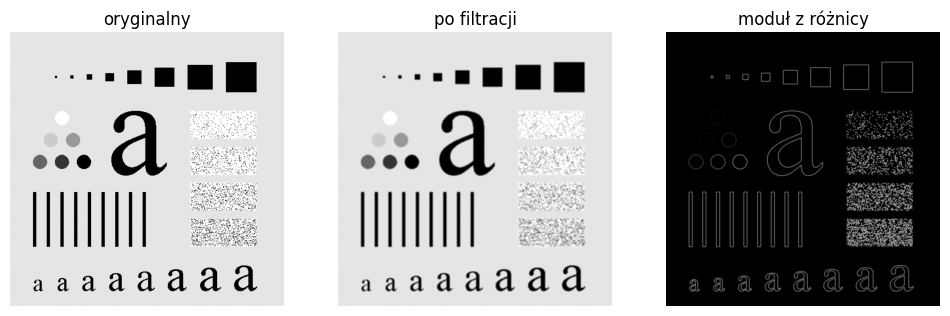

In [56]:
plansza = read_img("plansza.png")

def convolution(img, size):
    kernel = np.ones((size, size), np.float32)
    kernel = kernel / (size * size)
    result = cv2.filter2D(img, -1, kernel, borderType = cv2.BORDER_REPLICATE)
    return result

result = convolution(plansza, 3)
img_diff = cv2.absdiff(plansza, result)

def plot_diff(original, result, diff, title=""):
    fig, (p1,p2,p3) = plt.subplots(1, 3, figsize=(12,6))
    fig.suptitle(title, fontsize=16)

    p1.imshow(original, cmap='gray')
    p1.set_title("oryginalny")
    p1.axis("off")

    p2.imshow(result, cmap='gray')
    p2.set_title("po filtracji")
    p2.axis("off")

    p3.imshow(diff, cmap='gray')
    p3.set_title("moduł z różnicy")
    p3.axis("off")

    plt.show()

plot_diff(plansza, result, img_diff)

5. Na wspólnym rysunku wyświetl wyniki filtracji uśredniającej z oknem o rozmiarze 3, 5, 9, 15 i 35. 
Wykorzystaj polecenie `plt.subplot`. 
Przeanalizuj wpływ rozmiaru maski na wynik. 

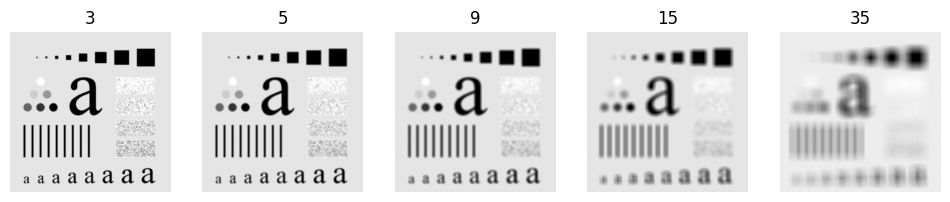

In [22]:
def averaging_filtering(img, kernels_size):
    fig, p = plt.subplots(1, 5, figsize=(12,6))
    for j, i in enumerate(kernels_size):
        p[j].imshow(convolution(img, i), cmap='gray')
        p[j].set_title(i)
        p[j].axis("off")
    plt.show()

averaging_filtering(plansza, [3, 5, 9, 15, 35])

6. Wczytaj obraz _lena.png_.
Zaobserwuj efekty filtracji dolnoprzepustowej dla obrazu rzeczywistego.

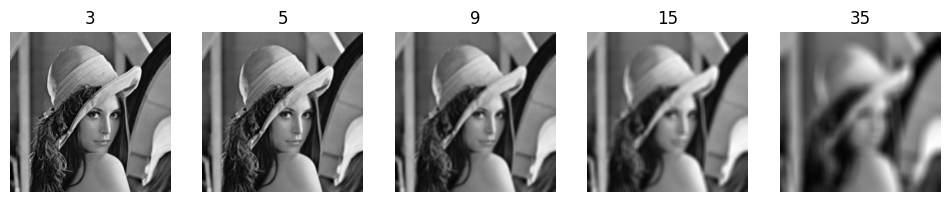

In [23]:
lena = read_img("lena.png")
averaging_filtering(lena, [3, 5, 9, 15, 35])

7. Niekorzystny efekt towarzyszący wykonanym filtracjom dolnoprzepustowym to utrata ostrości. 
Częściowo można go zniwelować poprzez odpowiedni dobór maski. 
Wykorzystaj maskę:  `M = np.array([1 2 1; 2 4 2; 1 2 1])`. 
Przed obliczeniami należy jeszcze wykonać normalizację - podzielić każdy element maski przez sumę wszystkich elementów: `M = M/sum(sum(M));`.
Tak przygotowaną maskę wykorzystaj w konwolucji - wyświetl wyniki tak jak wcześniej.
Możliwe jest też wykorzystywanie innych masek - współczynniki można dopasowywać do konkretnego problemu.

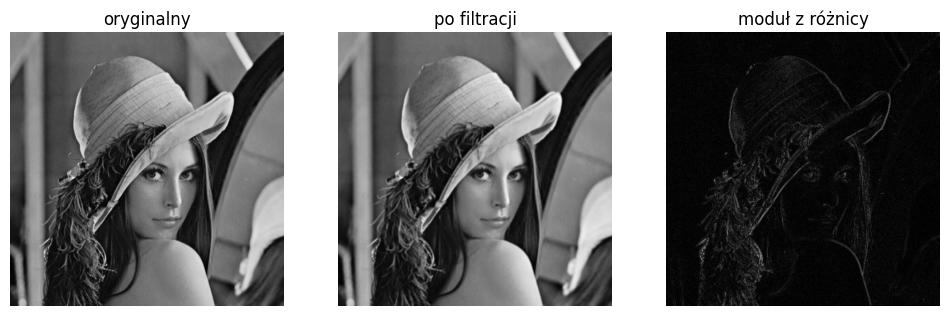

In [26]:
M = np.array([[1, 2, 1], [2, 4, 2], [1, 2, 1]])
M = M/sum(sum(M))

result = cv2.filter2D(lena, -1, M)
img_diff = cv2.absdiff(result, lena)

plot_diff(lena, result, img_diff)

8. Skuteczną i często wykorzystywaną maską jest tzw. maska Gasussa.
Jest to zbiór liczb, które aproksymują dwuwymiarowy rozkład Gaussa. 
Parametrem jest odchylenie standardowe i rozmiar maski.

9. Wykorzystując przygotowaną funkcję `fgaussian` stwórz maskę o rozmiarze $5 \times 5$ i odchyleniu standardowym 0.5.
  Wykorzystując funkcję `mesh` zwizualizuj filtr.
  Sprawdź jak parametr ``odchylenie standardowe'' wpływa na ``kształt'' filtru.

  Uwaga. W OpenCV dostępna jest *dedykowana* funkcja do filtracji Gaussa - `GaussianBlur`.
  Proszę na jednym przykładzie porównać jej działanie z użytym wyżej rozwiązaniem.

10. Wykonaj filtrację dla wybranych (2--3) wartości odchylenia standardowego.


In [33]:
def fgaussian(size, sigma):
     m = n = size
     h, k = m//2, n//2
     x, y = np.mgrid[-h:h+1, -k:k+1]
     g = np.exp(-(x**2 + y**2)/(2*sigma**2))
     return g /g.sum() 
    
    
def mesh(fun, size):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    

    X = np.arange(-size//2, size//2, 1)
    Y = np.arange(-size//2, size//2, 1)
    X, Y = np.meshgrid(X, Y)
    Z = fun
    
    ax.plot_surface(X, Y, Z)
    
    plt.show()


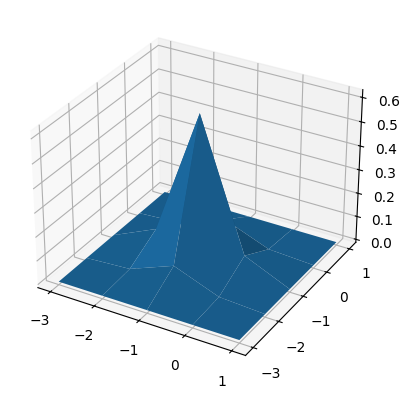

In [34]:
mesh(fgaussian(5, 0.5), 5)

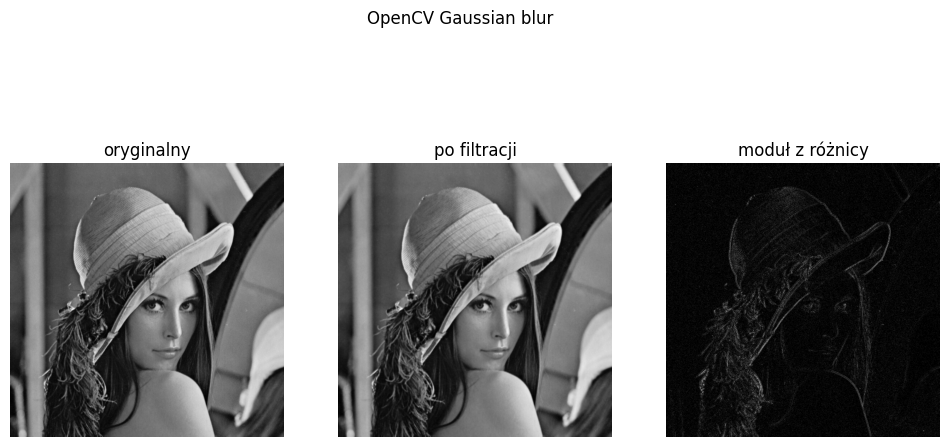

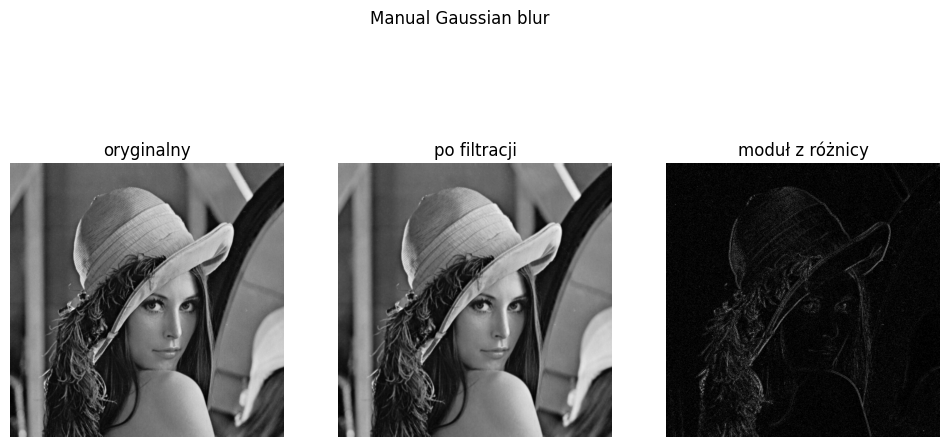

In [57]:
result = cv2.GaussianBlur(lena, (3, 3), 0.5)
img_diff=cv2.absdiff(result, lena)

result2 = cv2.filter2D(lena, -1, fgaussian(5, 0.5))
img_diff2 = cv2.absdiff(result2, lena)

plot_diff(lena, result, img_diff, "OpenCV Gaussian blur")
plot_diff(lena, result2, img_diff2, "Manual Gaussian blur")

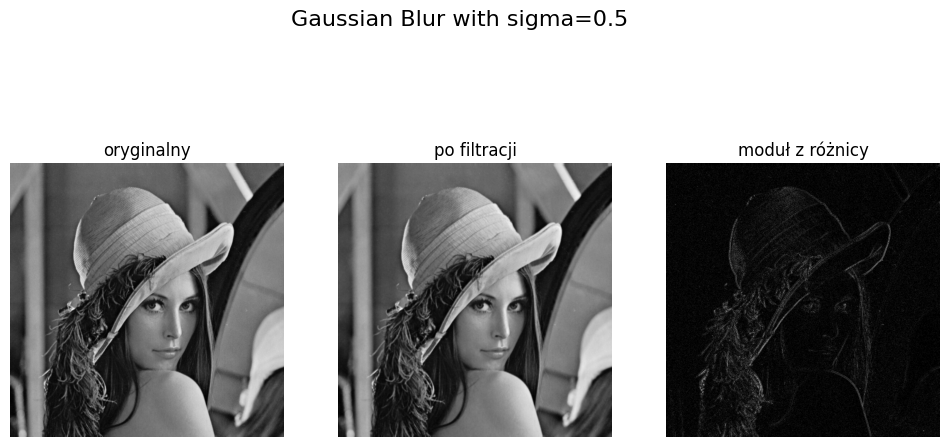

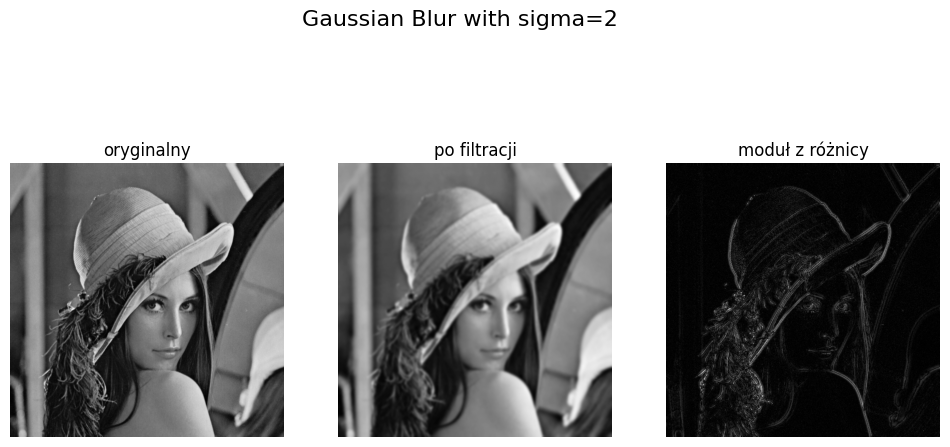

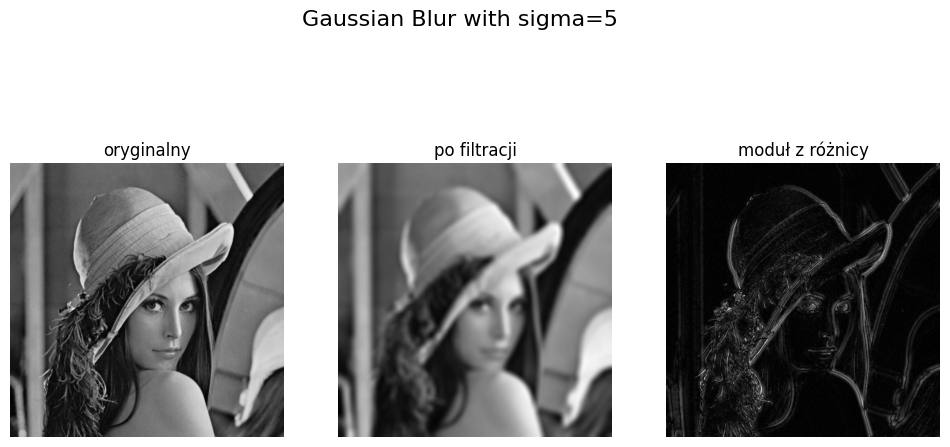

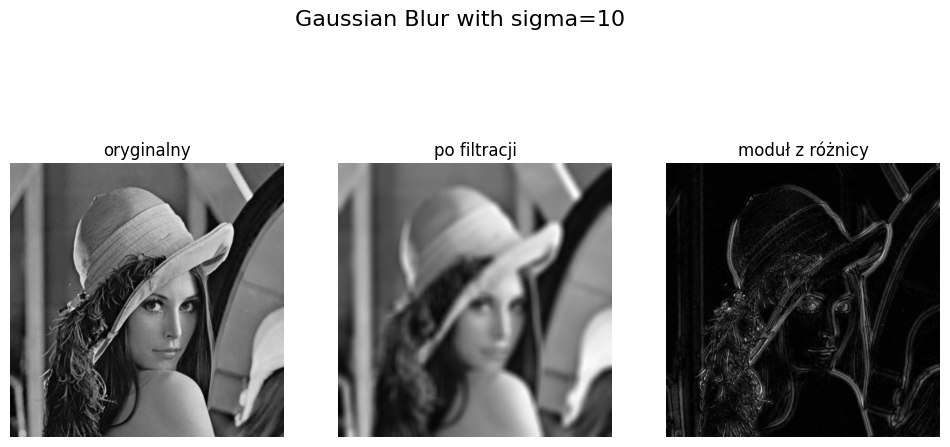

In [46]:
for i, val in enumerate([0.5, 2, 5, 10]):
    result = cv2.GaussianBlur(lena, (15, 15), val)
    img_diff=cv2.absdiff(result, lena)
    plot_diff(lena, result, img_diff, f"Gaussian Blur with sigma={val}")

### Filtry nieliniowe -- mediana

Filtry rozmywające redukują szum, ale niekorzystnie wpływają na ostrość obrazu.
Dlatego często wykorzystuje się filtry nieliniowe - np. filtr medianowy (dla przypomnienia: mediana - środkowa wartość w posortowanym ciągu liczb).

Podstawowa różnica pomiędzy filtrami liniowymi, a nieliniowymi polega na tym, że przy filtracji liniowej na nową wartość piksela ma wpływ wartość wszystkich pikseli z otoczenia (np. uśrednianie, czasem ważone), natomiast w przypadku filtracji nieliniowej jako nowy piksel wybierana jest któraś z wartości otoczenia - według jakiegoś wskaźnika (wartość największa, najmniejsza czy właśnie mediana).


1. Wczytaj obraz _lenaSzum.png_ (losowe 10% pikseli białych lub czarnych - tzw. zakłócenia impulsowe). Przeprowadź filtrację uśredniającą z rozmiarem maski 3x3. Wyświetl, podobnie jak wcześniej, oryginał, wynik filtracji i moduł z różnicy. Wykorzystując funkcję ``cv2.medianBlur` wykonaj filtrację medianową _lenaSzum.png_ (z rozmiarem maski $3 \times 3$). Wyświetl, podobnie jak wcześniej, oryginał, wynik filtracji i moduł z różnicy. Która filtracja lepiej radzi sobie z tego typu szumem?

  Uwaga. Taki sam efekt da również użycie funkcji `signal.medfilt2d`.


2. Przeprowadź filtrację uśredniającą, a następnie medianową obrazu _lena.png_.
   Wyniki porównaj - dla obu wyświetl: oryginał, wynik filtracji i moduł z różnicy.
   Szczególną uwagę zwróć na ostrość i krawędzie.
   W której filtracji krawędzie zostają lepiej zachowane?

3. Ciekawy efekt można uzyskać wykonując filtrację medianową wielokrotnie. Określa się go mianem  posteryzacji.  W wyniku przetwarzania z obrazka usunięte zostają detale, a duże obszary uzyskują tą samą wartość jasności.  Wykonaj operację mediany $5 \times 5$ na obrazie _lena.png_ 10-krotnie. (wykorzystaj np. pętlę `for`).


Inne filtry nieliniowe:
- filtr modowy - moda (dominanta) zamiast mediany,
- filtr olimpijski - średnia z podzbioru otoczenia (bez wartości ekstremalnych),
- hybrydowy filtr medianowy - mediana obliczana osobno w różnych podzbiorach otoczenia (np. kształt ``x'',``+''), a jako wynik brana jest mediana ze zbioru wartość elementu centralnego, mediana z ``x'' i mediana z ``+'',
- filtr minimalny i maksymalny (będą omówione przy okazji operacji morfologicznych w dalszej części kursu).


Warto zdawać sobie sprawę, z szerokich możliwości dopasowywania rodzaju filtracji do konkretnego rozważanego problemu i rodzaju zaszumienia występującego na obrazie.

## Filtry liniowe górnoprzepustowe (wyostrzające, wykrywające krawędzie)

Zadaniem filtrów górnoprzepustowych jest wydobywanie z obrazu składników odpowiedzialnych za szybkie zmiany jasności - konturów, krawędzi, drobnych elementów tekstury.

### Laplasjan (wykorzystanie drugiej pochodnej obrazu)

1. Wczytaj obraz _moon.png_.

2. Wprowadź podstawową maskę laplasjanu:
\begin{equation}
M = 
\begin{bmatrix}
0 & 1& 0 \\ 1 & -4 & 1 \\ 0 & 1 & 0
\end{bmatrix}
\end{equation}

3. Przed rozpoczęciem obliczeń należy dokonać normalizacji maski - dla rozmiaru $3 \times 3$ podzielić każdy element przez 9.
   Proszę zwrócić uwagę, że nie można tu zastosować takiej samej normalizacji, jak dla filtrów dolnoprzepustowanych, gdyż skutkowałby to dzieleniem przez 0.

4. Wykonaj konwolucję obrazu z maską (`c2.filter2D`). Przed wyświetleniem, wynikowy obraz należy poddać normalizacji (występują ujemne wartości). Najczęściej wykonuje się jedną z dwóch operacji:
- skalowanie (np. poprzez dodatnie 128 do każdego z pikseli),
- moduł (wartość bezwzględna).

Wykonaj obie normalizacje. 
Na wspólnym wykresie wyświetl obraz oryginalny oraz przefiltrowany po obu normalizacjach. 

7. Efekt wyostrzenia uzyskuje się po odjęciu/dodaniu (zależy do maski) rezultatu filtracji laplasjanowej i oryginalnego obrazu. Wyświetl na jednym wykresie: obraz oryginalny, sumę oryginału i wyniku filtracji oraz różnicę (bezwzględną) oryginału i wyniku filtracji.
 Uwaga. Aby uniknąć artefaktów, należy obraz wejściowy przekonwertować do formatu ze znakiem.



### Gradienty (wykorzystanie pierwszej pochodnej obrazu)

1. Wczytaj obraz _kw.png_. Stwórz odpowiednie maski opisane w kolejnych punktach i dokonaj filtracji.
2. Wykorzystując gradient Robertsa przeprowadź detekcję krawędzi - poprzez wykonanie konwolucji obrazu z daną maską:
\begin{equation}
R1 = \begin{bmatrix} 0 & 0 & 0 \\ -1 & 0 & 0 \\ 0 & 1 & 0 \end{bmatrix}   
R2 = \begin{bmatrix} 0 & 0 & 0 \\ 0 & 0 & -1 \\ 0 & 1 & 0 \end{bmatrix}
\end{equation}

Wykorzystaj stworzony wcześniej kod (przy laplasjanie) - dwie metody normalizacji oraz sposób wyświetlania.

3. Analogicznie przeprowadź detekcję krawędzi za pomocą gradientu Prewitta (pionowy i poziomy)
\begin{equation}
P1 = \begin{bmatrix} -1 & 0 & 1 \\ -1 & 0 & 1 \\ -1 & 0 & 1 \end{bmatrix}   
P2 = \begin{bmatrix} -1 & -1 & -1 \\ 0 & 0 & 0 \\ 1 & 1 & 1 \end{bmatrix}
\end{equation}

4. Podobnie skonstruowany jest gradient Sobela (występuje osiem masek, zaprezentowane są dwie ``prostopadłe''):
\begin{equation}
S1 = \begin{bmatrix} -1 & 0 & 1 \\ -2 & 0 & 2 \\ -1 & 0 & 1 \end{bmatrix}   
S2 = \begin{bmatrix} -1 & -2 & -1 \\ 0 & 0 & 0 \\ 1 & 2 & 1 \end{bmatrix}
\end{equation}

Przeprowadź detekcję krawędzi za pomocą gradientu Sobela. 

5. Na podstawie dwóch ortogonalnych masek np. Sobela można stworzyć tzw. filtr kombinowany - pierwiastek kwadratowy z sumy kwadratów gradientów:
\begin{equation}
OW = \sqrt{(O * S1)^2 + (O * S2)^2}
\end{equation}
gdzie:  $OW$ - obraz wyjściowy, $O$ - obraz oryginalny (wejściowy), $S1,S2$ - maski Sobela, $*$ - operacja konwolucji.

Zaimplementuj filtr kombinowany.

Uwaga. Proszę zwrócić uwagę na konieczność zmiany formatu danych obrazu wejściowego - na typ znakiem



6. Istnieje alternatywna wersja filtra kombinowanego, która zamiast pierwiastka z sumy kwadratów wykorzystuje sumę modułów (prostsze obliczenia). 
Zaimplementuj tę wersję. 

7. Wczytaj plik _jet.png_ (zamiast _kw.png_).
Sprawdź działanie obu wariantów filtracji kombinowanej.